In [ ]:

import os
import sys
import getpass
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List
import logging

### change directory to import more scripts
sys.path.append(str(Path().resolve().parents[0]))

import generate_wind
from utils import tools, clean_data, raw_to_db

if os.getcwd().split(os.sep)[-1] == 'evaluation':
    os.chdir('..')

In [ ]:
config = tools.load_config('config.yaml')
db_config = config['write']['db_conf']
features = config['features']
threshold = config['write']['threshold']
directory = config['data']['dir']
solar_dir = os.path.join(config['data']['raw_dir'], 'solar')
wind_dir = os.path.join(config['data']['raw_dir'], 'wind')
passw = getpass.getpass("Enter postgres users password: ")
config['write']['db_conf']['passw'] = passw
features = config['features']
vars = config['scraping']['vars']
from_date = config['data']['from_date']
hist_date = config['data']['hist_date']
column_names = [
    "Stations_id", "von_datum", "bis_datum", "Stationshoehe",
    "geoBreite", "geoLaenge", "Stationsname", "Bundesland", "Abgabe"
]


In [6]:
def analyze_nan_rows(list_of_dataframes: List[pd.DataFrame],
                     features: List[str]) -> List[int]:
    left_list = []
    ticks = np.arange(0.001, 0.051, 0.001)
    for threshold in ticks:
        stations = []
        for i, df in enumerate(list_of_dataframes):
            low_values = False
            station_id = df.station_id.iloc[0]
            for feature in features:
                share_missing = df[feature].isna().sum() / len(df)
                #print(f'Station {station_id} and feature {feature} has {share_missing*100}% missing values.')
                if share_missing > round(threshold, 3):
                    low_values = True
                    break
            if low_values:
                stations.append(station_id)
        n_left = len(list_of_dataframes)-len(stations)
        left_list.append(n_left)
    return left_list

In [3]:
stations = raw_to_db.get_all_stations_files(dir=directory,
                                            column_names=column_names,
                                            vars=vars)

In [ ]:
pv_features, wind_features = clean_data.relevant_features(features=features)
master_data = tools.get_master_data(db_config=db_config)
logging.info('Getting distinct station ids')
station_ids = clean_data.get_station_ids(db_config=db_config)
logging.info('Getting station dataframes')
frames = clean_data.iterate_stations(db_config=db_config,
                                     station_ids=station_ids)

Iterate over stations: 100%|██████████| 202/202 [03:54<00:00,  1.16s/it]


In [6]:
left_list_pv = analyze_nan_rows(frames, pv_features)
left_list_wind = analyze_nan_rows(frames, wind_features)

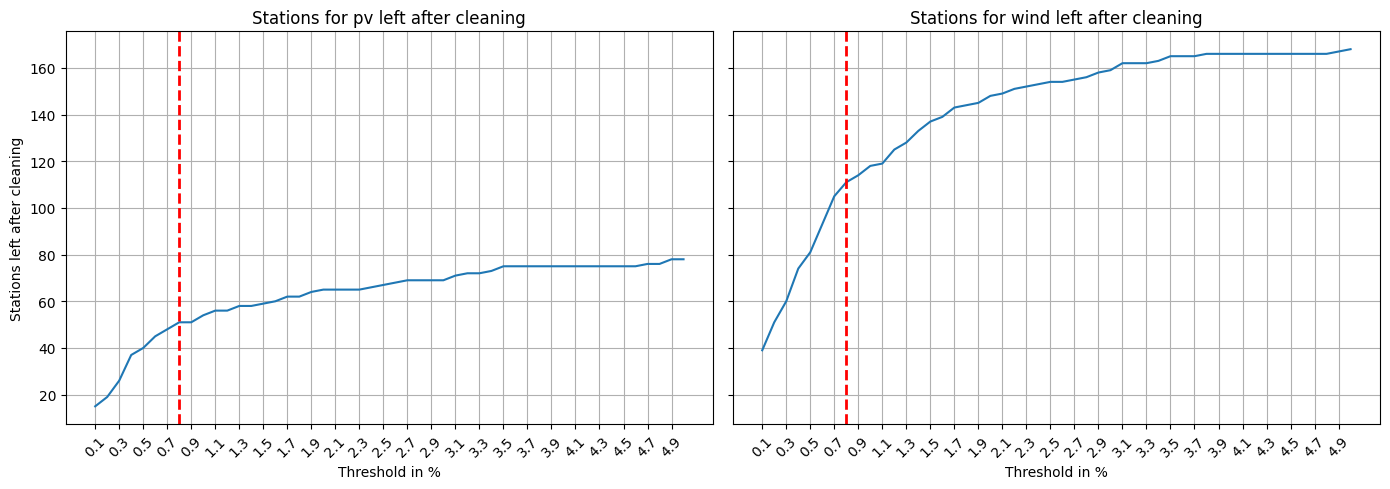

In [8]:
# Plot
ticks = np.arange(0.1, 5.1, 0.1)
x_vals = ticks
x_ticks_shown = x_vals[::2]
x_labels_shown = [f"{x:.1f}" for x in ticks[::2]]
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1
axes[0].plot(x_vals, left_list_pv)
axes[0].axvline(x=0.8, color='red', linestyle='--', linewidth=2)
axes[0].set_title("Stations for pv left after cleaning")
axes[0].set_xticks(x_ticks_shown)
axes[0].set_xticklabels(x_labels_shown, rotation=45)
axes[0].set_xlabel("Threshold in %")
axes[0].set_ylabel("Stations left after cleaning")
axes[0].grid()

# Plot 2
axes[1].plot(x_vals, left_list_wind)
axes[1].axvline(x=0.8, color='red', linestyle='--', linewidth=2)
axes[1].set_title("Stations for wind left after cleaning")
axes[1].set_xticks(x_ticks_shown)
axes[1].set_xticklabels(x_labels_shown, rotation=45)
axes[1].set_xlabel("Threshold in %")
axes[1].grid()

# Layout anpassen
plt.tight_layout()
plt.show()